Task Website: https://sites.google.com/view/simpletext-sota/home
Competition: https://codalab.lisn.upsaclay.fr/competitions/16616

Dataset: https://github.com/jd-coderepos/sota/tree/master



In [93]:
import os
if os.getcwd() == '/home/user/code':
    os.chdir('/home/user/code/nlp2024_ClefTask4SOTA')


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read all Splits

In [94]:
NOT_FOUND = "unanswerable\n"
TRAIN_PATH = "./data/train"

In [95]:

import os
import json

TRAIN_PATH = "./data/train"
VAL_PATH = "./data/validation"
TEST_PHASE1_PATH = "./data/test1-few-shot-papers"
TEST_PATH = "./data/test2-zero-shot-papers"


def path_join(*args):
    return os.path.join(*args).replace('\\', '/') 

def find(extension, *args):
    p = path_join(*args)
    res = list(filter(lambda x: x.endswith(extension), os.listdir(p)))
    if res:
        return path_join(p, res[0])
    else:
        return None


def get_num_files(path):
    return len([(p, find("tex", path, p), find("json", path, p)) for p in os.listdir(path)])

def get(path):
    return [(p, find("tex", path, p), find("json", path, p)) for p in os.listdir(path)]

In [96]:
import pandas as pd

r = [
    {
        "split": "train",
        "volume": get_num_files(TRAIN_PATH)
    },
    {
        "split": "validation",
        "volume": get_num_files(VAL_PATH)
    },
    {
        "split": "test few shot phase",
        "volume": get_num_files(TEST_PHASE1_PATH)
    },
    {
        "split": "test zero shot phase",
        "volume": get_num_files(TEST_PATH)
    },
]

df = pd.DataFrame(r)

In [97]:
print(df.to_latex(index=False))

\begin{tabular}{lr}
\toprule
               split &  volume \\
\midrule
               train &   12288 \\
          validation &     100 \\
 test few shot phase &    1401 \\
test zero shot phase &     789 \\
\bottomrule
\end{tabular}



# Training Data analysis

In [98]:
import pandas as pd

all_paths = get(TRAIN_PATH)

def read(i):
    # print(i)
    tex = None
    jsn = None
    try:
        i, tex_path, jsn_path = all_paths[i]
    except Exception as ex:
        print(i)
        raise ex
    tex, jsn = None, None

    try:
        with open(tex_path) as f:
            tex = f.read()
    except: # tex not read
        pass
    
    if jsn_path:
        with open(jsn_path, encoding="utf-8") as f:
            jsn = f.read()
            try:
                jsn = eval(jsn)
            except:
                pass #"unanswerable" is not a dict, no eval possible/necessary
    
    return i, tex, jsn


n = len(all_paths)
data = []
for i, t, j in [read(i) for i in range(n)]:
    # if j and j != 'unanswerable\n':
    data.append((i, t, j))



In [99]:
df_raw = pd.DataFrame(data)
df_raw = df_raw.rename({0: "id", 1: "tex", 2: "jsn"}, axis=1)
df_raw


,id,tex,jsn
0,2205.07139v1,\documentclass[runningheads]{llncs}\n\usepacka...,[{'LEADERBOARD': {'Task': 'Thoracic Disease Cl...
1,1908.04531v2,\documentclass{article}\n\n\n\usepackage{arxiv...,[{'LEADERBOARD': {'Task': 'Hate Speech Detecti...
2,1007.3769,"\documentclass{LMCS}\n\n\mathcode`:=""003A \ma...",unanswerable\n
3,1408.5825,"\n\n\n\n\n\documentclass[10pt,draftcls,onecolu...",unanswerable\n
4,2104.08663v2,\pdfoutput=1\n\n\n\documentclass[11pt]{article...,unanswerable\n
...,...,...,...
12283,0907.0649,\n\n\documentclass[twoside]{article}\n\usepack...,unanswerable\n
12284,2207.07922v1,\n\n\documentclass[runningheads]{llncs}\n\usep...,[{'LEADERBOARD': {'Task': 'Semi-Supervised Vid...
12285,2204.14047v2,\documentclass[sigconf]{acmart}\n\n\usepackage...,[{'LEADERBOARD': {'Task': 'Video Quality Asses...
12286,1611.06067v1,\def\year{2017}\relax\n\documentclass[letterpa...,[{'LEADERBOARD': {'Task': 'Skeleton Based Acti...


## how many are parsable?

In [100]:
from TexSoup import TexSoup

def is_parsable(t):
    try:
        soup = TexSoup(t)
        return True
    except:
        return False
    
# parsable = df_raw["tex"][:1000].apply(is_parsable)

In [101]:
# parsable

## Is ID unique?

In [102]:
# is "id" unique?

total_ids = len(df_raw["id"])
nonduplicate_ids = len(df_raw["id"].drop_duplicates())
print(total_ids)
print(nonduplicate_ids)
# -> yes

12288
12288


# Tex Files

In [103]:
# how long are the tex?

df_raw["tex_len"] = df_raw["tex"].str.len()

In [104]:
# longest doc
df_raw.loc[df_raw["tex_len"].idxmax()]

id                                              2210.05974v3
tex        \documentclass{article}\n\usepackage[utf8]{inp...
jsn        [{'LEADERBOARD': {'Task': 'Click-Through Rate ...
tex_len                                            4539917.0
Name: 9878, dtype: object

In [105]:
tex = df_raw.loc[df_raw["tex_len"].idxmax()]["tex"]

In [106]:
# top 10 longest docs
df_t10 = df_raw.loc[df_raw["tex_len"].nlargest(10).index]


# are they pgfpictures in there?
df_t10["pgfpicture"] = df_t10["tex"].str.contains("pgfpicture")

df_t10

,id,tex,jsn,tex_len,pgfpicture
9878,2210.05974v3,\documentclass{article}\n\usepackage[utf8]{inp...,[{'LEADERBOARD': {'Task': 'Click-Through Rate ...,4539917.0,True
10430,1906.12269v1,\documentclass[sigconf]{acmart}\n\usepackage{x...,[{'LEADERBOARD': {'Task': 'Node Classification...,2454516.0,True
10457,1911.05485v6,\documentclass{article}\n\n\PassOptionsToPacka...,[{'LEADERBOARD': {'Task': 'Node Classification...,2018664.0,True
1702,1911.05485v5,\documentclass{article}\n\n\PassOptionsToPacka...,unanswerable\n,2018656.0,True
5024,1510.06516,"\documentclass[letterpaper,10pt,conference,two...",unanswerable\n,885157.0,True
3017,2310.16248v2,\pdfoutput=1\n\n\documentclass[11pt]{article}\...,[{'LEADERBOARD': {'Task': 'Language Identifica...,839134.0,False
12277,1406.6281,"\n\documentclass[journal,transmag]{IEEEtran}\n...",unanswerable\n,828241.0,False
7322,1803.06815v3,\n\n\documentclass[runningheads]{llncs}\n\usep...,[{'LEADERBOARD': {'Task': 'Semantic Segmentati...,736871.0,False
6602,1911.10927v1,"\documentclass[10pt,twocolumn,letterpaper]{art...",[{'LEADERBOARD': {'Task': 'Video Super-Resolut...,716000.0,False
735,1810.05997v6,\documentclass{article} \usepackage{iclr2019_c...,[{'LEADERBOARD': {'Task': 'Node Classification...,674777.0,True


In [125]:
df_raw["tex_len"].min()

137.0

In [126]:
df_raw.loc[df_raw["tex_len"].idxmin()]

id                                                      2301.05124v1
tex                Introduction\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
jsn                [{'LEADERBOARD': {'Task': 'Object Detection', ...
tex_len                                                        137.0
isUnanswerable                                                 False
isNone                                                         False
numLeaderboards                                                   12
hasLeaderboards                                                 True
Name: 10103, dtype: object

## remove pgfpicture

In [107]:
from src.content_extraction import _find_begin_end


def remove_pgfpictures(tex):
    pgfpictures = _find_begin_end(tex, "pgfpicture")
    for _, pgfpicture in pgfpictures:
        tex = tex.replace(pgfpicture, "")
    return tex

In [108]:
df = df_raw.copy()
df["tex"] = df["tex"].apply(remove_pgfpictures)
df["tex_len_clean"] = df["tex"].str.len()

In [109]:
df["tex_len_clean"]

0        25291.0
1        51286.0
2        73104.0
3        36681.0
4        87071.0
          ...   
12283    35442.0
12284    44277.0
12285    49320.0
12286    43106.0
12287    62331.0
Name: tex_len_clean, Length: 12288, dtype: float64

In [110]:
df["tex_len_clean"].max()

839134.0

In [111]:
df["tex_len_clean"].describe()

count     11920.000000
mean      46241.425503
std       30938.414346
min         137.000000
25%       29077.000000
50%       42629.000000
75%       56679.000000
max      839134.000000
Name: tex_len_clean, dtype: float64

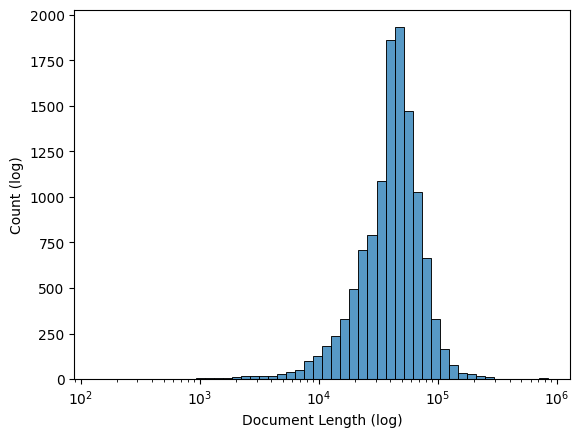

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.histplot(df["tex_len_clean"], bins = 50, log_scale=True)

# plt.yscale("log")
# plt.xscale("log")
ax.set(xlabel='Document Length (log)', ylabel='Count (log)')

plt.savefig("imgs/doc_len_hist.png")


# JSON Files

## How many are Null / Unanswerable?

In [113]:
df = df_raw
NOT_FOUND = "unanswerable\n"

df["isUnanswerable"] = df["jsn"] == NOT_FOUND
df["isNone"] = df["jsn"].isnull()

print(f"total len: {len(df)}")
print(f"None: {len(df[df['isNone']])}")
print(f"Unanswerable: {len(df[df['isUnanswerable']])}")
# print(f"Does not start with [: {len(df[~df['jsn'].astype(str).str.startswith("[")])}")



total len: 12288
None: 0
Unanswerable: 4352


# Leaderboard details

In [114]:
df["numLeaderboards"] = df["jsn"].apply(lambda c: len(c) if c and c != NOT_FOUND else 0)
df["hasLeaderboards"] = df["numLeaderboards"] > 0

print(f"= 0: {len(df[df['numLeaderboards'] == 0])}")
print(f"> 0: {len(df[df['numLeaderboards'] > 0])}")
print(f"> 5: {len(df[df['numLeaderboards'] > 5])}")
print(f"> 10: {len(df[df['numLeaderboards'] > 10])}")
print(f"> 40: {len(df[df['numLeaderboards'] > 40])}")
print(f"> 100: {len(df[df['numLeaderboards'] > 100])}")
print(f"> 200: {len(df[df['numLeaderboards'] > 200])}")

df_lt40 = df[df["numLeaderboards"] < 40]

= 0: 4352
> 0: 7936
> 5: 2912
> 10: 1297
> 40: 122
> 100: 17
> 200: 1


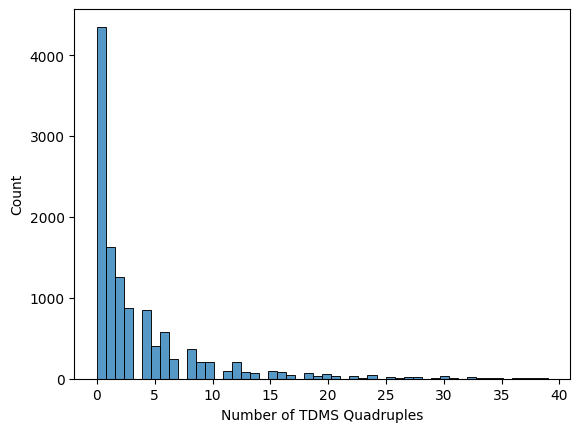

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.histplot(df[df["numLeaderboards"]<40]["numLeaderboards"], bins = 50, log_scale=False)
# ax = sns.histplot(df["numLeaderboards"], bins = 50, log_scale=False)

ax.set(xlabel='Number of TDMS Quadruples', ylabel='Count')

plt.savefig("imgs/annotation_len_hist.png")

In [116]:
# pct_hasLeaderboard =  len(df[df["hasLeaderboards"] == False]) / len(df[df["hasLeaderboards"] == True])
pct_hasLeaderboard =  len(df[df["hasLeaderboards"]]) / len(df)
pct_hasLeaderboard

0.6458333333333334

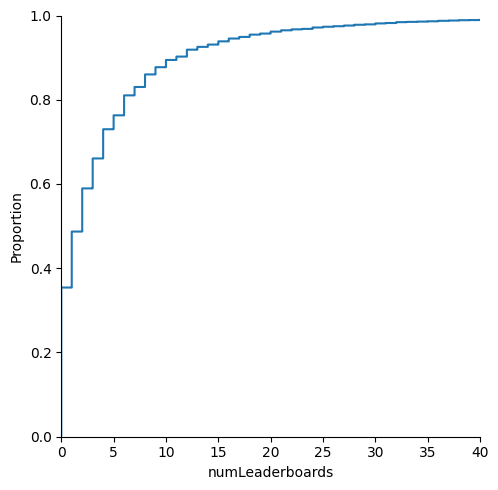

In [117]:
import seaborn as sns

ax = sns.displot(df["numLeaderboards"], kind="ecdf")
ax.set(xlim=(0, 40))

[(0.0, 40.0)]

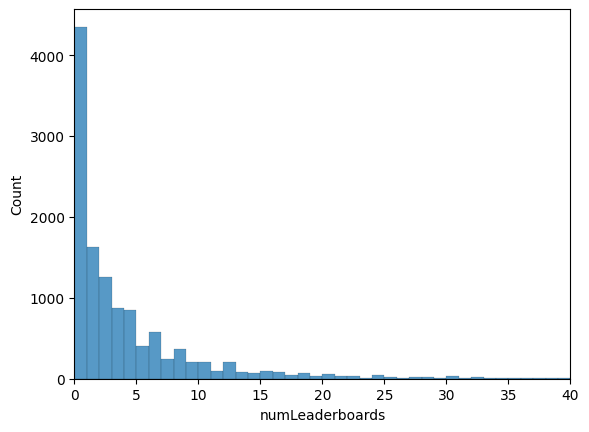

In [118]:
ax = sns.histplot(df["numLeaderboards"], bins=max(df["numLeaderboards"]))
ax.set(xlim=(0, 40))

In [119]:
df.loc[df["numLeaderboards"].idxmax()]

id                                                      2210.07606v1
tex                \documentclass{article}\n\n\n\n\n\n\usepackage...
jsn                [{'LEADERBOARD': {'Task': 'Node Classification...
tex_len                                                     180536.0
isUnanswerable                                                 False
isNone                                                         False
numLeaderboards                                                  356
hasLeaderboards                                                 True
Name: 4701, dtype: object

In [120]:
# Split dataframes into paper & leaderboard entries

df_entries = df[["id", "jsn"]]

df_entries = df_entries.explode("jsn")

df_entries["jsn"] = df_entries["jsn"].apply(lambda c: None if not c or c == NOT_FOUND else c["LEADERBOARD"])
df_entries = df_entries.dropna()

df_entries = pd.concat([df_entries, df_entries["jsn"].apply(pd.Series)], axis=1)
df_entries

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f624eea79a0>>
Traceback (most recent call last):
  File "/home/user/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


,id,jsn,Task,Dataset,Metric,Score
0,2205.07139v1,"{'Task': 'Thoracic Disease Classification', 'D...",Thoracic Disease Classification,ChestX-ray14,AUROC,78.33
1,1908.04531v2,"{'Task': 'Hate Speech Detection', 'Dataset': '...",Hate Speech Detection,DKhate,F1,0.70
5,1911.04127v1,"{'Task': 'Temporal Action Localization', 'Data...",Temporal Action Localization,FineAction,mAP,6.75
5,1911.04127v1,"{'Task': 'Temporal Action Localization', 'Data...",Temporal Action Localization,FineAction,mAP IOU@0.5,10.65
5,1911.04127v1,"{'Task': 'Temporal Action Localization', 'Data...",Temporal Action Localization,FineAction,mAP IOU@0.75,6.43
...,...,...,...,...,...,...
12287,1903.11059v2,"{'Task': 'Neural Architecture Search', 'Datase...",Neural Architecture Search,ImageNet,Accuracy,75.5
12287,1903.11059v2,"{'Task': 'Neural Architecture Search', 'Datase...",Neural Architecture Search,ImageNet,Params,5.4M
12287,1903.11059v2,"{'Task': 'Neural Architecture Search', 'Datase...",Neural Architecture Search,CIFAR-10,Top-1 Error Rate,2.82%
12287,1903.11059v2,"{'Task': 'Neural Architecture Search', 'Datase...",Neural Architecture Search,CIFAR-10,Search Time (GPU days),224


In [ ]:
# Tasks
tasks = df_entries.groupby("Task").count()["id"].sort_values(ascending=False)
print(len(tasks))

# Top 20
tasks[:20]

1372


Task
Image Classification                         2273
Atari Games                                  1448
Node Classification                          1113
Object Detection                             1001
Video Retrieval                               997
Link Prediction                               941
Semantic Segmentation                         901
Semi-Supervised Video Object Segmentation     890
3D Human Pose Estimation                      889
Question Answering                            866
Image Super-Resolution                        669
Person Re-Identification                      548
Image Generation                              510
Visual Question Answering (VQA)               500
Neural Architecture Search                    488
Monocular Depth Estimation                    485
Anomaly Detection                             474
Video Super-Resolution                        467
Node Property Prediction                      447
3D Object Detection                          

In [ ]:
# Dataset
dataset = df_entries.groupby("Dataset").count()["id"].sort_values(ascending=False)
print(len(dataset))

# Top 20
dataset[:20]

4808


Dataset
ImageNet                                      1603
COCO test-dev                                  792
Human3.6M                                      624
CIFAR-10                                       585
COCO minival                                   310
YouTube-VOS 2018                               295
CIFAR-100                                      252
MSR-VTT-1kA                                    247
FB15k-237                                      244
MSU Super-Resolution for Video Compression     225
DAVIS 2017 (val)                               222
ChEBI-20                                       220
WN18RR                                         212
Kinetics-400                                   212
DAVIS 2016                                     211
3DPW                                           197
Winoground                                     196
COCO                                           192
MPI-INF-3DHP                                   189
IconQA                 

In [ ]:
# Metric
metric = df_entries.groupby("Metric").count()["id"].sort_values(ascending=False)
print(len(metric))

# Top 20
metric[:20]

2874


Metric
Accuracy              4362
Score                 1515
F1                    1384
PSNR                  1144
mAP                    829
mIoU                   817
SSIM                   799
Top 1 Accuracy         789
1:1 Accuracy           787
Number of params       701
FID                    616
AP                     586
Mean IoU               562
MAE                    541
Top-1 Accuracy         483
AUC                    447
Percentage correct     345
Accuracy (%)           337
Rank-1                 329
MRR                    314
Name: id, dtype: int64

# Which entries can be found in the text?

In [ ]:
def is_in_tex(item, tex):
    return str(item).lower() in str(tex).lower()

In [ ]:
df_combined

,id,jsn,Task,Dataset,Metric,Score,tex
0,2205.07139v1,"{'Task': 'Thoracic Disease Classification', 'D...",Thoracic Disease Classification,ChestX-ray14,AUROC,78.33,\documentclass[runningheads]{llncs}\n\usepacka...
1,1908.04531v2,"{'Task': 'Hate Speech Detection', 'Dataset': '...",Hate Speech Detection,DKhate,F1,0.70,\documentclass{article}\n\n\n\usepackage{arxiv...
2,1911.04127v1,"{'Task': 'Temporal Action Localization', 'Data...",Temporal Action Localization,FineAction,mAP,6.75,\def\year{2020}\relax\n\documentclass[letterpa...
3,1911.04127v1,"{'Task': 'Temporal Action Localization', 'Data...",Temporal Action Localization,FineAction,mAP IOU@0.5,10.65,\def\year{2020}\relax\n\documentclass[letterpa...
4,1911.04127v1,"{'Task': 'Temporal Action Localization', 'Data...",Temporal Action Localization,FineAction,mAP IOU@0.75,6.43,\def\year{2020}\relax\n\documentclass[letterpa...
...,...,...,...,...,...,...,...
54967,1903.11059v2,"{'Task': 'Neural Architecture Search', 'Datase...",Neural Architecture Search,ImageNet,Accuracy,75.5,"\documentclass[10pt,twocolumn,letterpaper]{art..."
54968,1903.11059v2,"{'Task': 'Neural Architecture Search', 'Datase...",Neural Architecture Search,ImageNet,Params,5.4M,"\documentclass[10pt,twocolumn,letterpaper]{art..."
54969,1903.11059v2,"{'Task': 'Neural Architecture Search', 'Datase...",Neural Architecture Search,CIFAR-10,Top-1 Error Rate,2.82%,"\documentclass[10pt,twocolumn,letterpaper]{art..."
54970,1903.11059v2,"{'Task': 'Neural Architecture Search', 'Datase...",Neural Architecture Search,CIFAR-10,Search Time (GPU days),224,"\documentclass[10pt,twocolumn,letterpaper]{art..."


In [ ]:
df_combined = df_entries.merge(df[["id", "tex"]],on="id")
df_combined["Task_found"] = df_combined.apply(lambda row: str(row["Task"]) in str(row["tex"]), axis=1)
df_combined["Dataset_found"] = df_combined.apply(lambda row: str(row["Dataset"]) in str(row["tex"]), axis=1)
df_combined["Metric_found"] = df_combined.apply(lambda row: str(row["Metric"]) in str(row["tex"]), axis=1)
df_combined["Score_found"] = df_combined.apply(lambda row: str(row["Score"]) in str(row["tex"]), axis=1)

In [ ]:
df_combined.dtypes

id               object
jsn              object
Task             object
Dataset          object
Metric           object
Score            object
tex              object
Task_found         bool
Dataset_found      bool
Metric_found       bool
Score_found        bool
dtype: object

In [ ]:
len(df_combined[df_combined['Task_found']])

20431

In [ ]:
len(df_combined[df_combined['Dataset_found']])

26052

In [ ]:
len(df_combined[df_combined['Metric_found']])

20591

In [ ]:
len(df_combined[df_combined['Score_found']])

32381

In [ ]:
tot = len(df_combined)
t_found = len(df_combined[df_combined['Task_found']])
ds_found = len(df_combined[df_combined['Dataset_found']])
metric_found = len(df_combined[df_combined['Metric_found']])
score_found = len(df_combined[df_combined['Score_found']])
print(f"total TDMS: {len(df_combined)}")
print(f"Task found: {t_found} -> {t_found/tot}")
print(f"Dataset found: {ds_found} -> {ds_found/tot}")
print(f"Metric found: {metric_found} -> {metric_found/tot}")
print(f"Score found: {score_found} -> {score_found/tot}")

total TDMS: 54972
Task found: 20431 -> 0.371661936986102
Dataset found: 26052 -> 0.47391399257803973
Metric found: 20591 -> 0.3745725096412719
Score found: 32381 -> 0.5890453321691043


In [ ]:
df_combined

,id,jsn,Task,Dataset,Metric,Score,tex,Task_found,Dataset_found,Metric_found,Score_found
0,2205.07139v1,"{'Task': 'Thoracic Disease Classification', 'D...",Thoracic Disease Classification,ChestX-ray14,AUROC,78.33,\documentclass[runningheads]{llncs}\n\usepacka...,False,True,True,True
1,1908.04531v2,"{'Task': 'Hate Speech Detection', 'Dataset': '...",Hate Speech Detection,DKhate,F1,0.70,\documentclass{article}\n\n\n\usepackage{arxiv...,True,False,True,True
2,1911.04127v1,"{'Task': 'Temporal Action Localization', 'Data...",Temporal Action Localization,FineAction,mAP,6.75,\def\year{2020}\relax\n\documentclass[letterpa...,False,False,False,True
3,1911.04127v1,"{'Task': 'Temporal Action Localization', 'Data...",Temporal Action Localization,FineAction,mAP IOU@0.5,10.65,\def\year{2020}\relax\n\documentclass[letterpa...,False,False,False,False
4,1911.04127v1,"{'Task': 'Temporal Action Localization', 'Data...",Temporal Action Localization,FineAction,mAP IOU@0.75,6.43,\def\year{2020}\relax\n\documentclass[letterpa...,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
54967,1903.11059v2,"{'Task': 'Neural Architecture Search', 'Datase...",Neural Architecture Search,ImageNet,Accuracy,75.5,"\documentclass[10pt,twocolumn,letterpaper]{art...",True,True,True,True
54968,1903.11059v2,"{'Task': 'Neural Architecture Search', 'Datase...",Neural Architecture Search,ImageNet,Params,5.4M,"\documentclass[10pt,twocolumn,letterpaper]{art...",True,True,True,True
54969,1903.11059v2,"{'Task': 'Neural Architecture Search', 'Datase...",Neural Architecture Search,CIFAR-10,Top-1 Error Rate,2.82%,"\documentclass[10pt,twocolumn,letterpaper]{art...",True,True,False,False
54970,1903.11059v2,"{'Task': 'Neural Architecture Search', 'Datase...",Neural Architecture Search,CIFAR-10,Search Time (GPU days),224,"\documentclass[10pt,twocolumn,letterpaper]{art...",True,True,False,True


# Partial hits?

In [ ]:
int(True)

1

In [ ]:
def partial_hit(row):
    return f'{int(row["Task_found"])}{int(row["Dataset_found"])}{int(row["Metric_found"])}{int(row["Score_found"])}'

In [ ]:
df_combined.loc[100]

id                                                    2306.11341v1
jsn              {'Task': 'Text to Video Retrieval', 'Dataset':...
Task                                       Text to Video Retrieval
Dataset                                            MSVD-Indonesian
Metric                                                        R@10
Score                                                         74.9
tex              \documentclass{article}\n\n\n\usepackage{PRIME...
Task_found                                                   False
Dataset_found                                                 True
Metric_found                                                  True
Score_found                                                   True
Name: 100, dtype: object

In [ ]:
df_combined["partials"] = df_combined.apply(partial_hit, axis=1)

In [ ]:
df_partials = df_combined.groupby("partials")["id"].count()

df_partials

partials
0000    7941
0001    5252
0010    2091
0011    3718
0100    4069
0101    5840
0110    1864
0111    3766
1000    2120
1001    3105
1010    1332
1011    3361
1100    1975
1101    4079
1110    1199
1111    3260
Name: id, dtype: int64

0000    7003 -> k
0001    4772 -> no
0010    1870 -> no
0011    3465 -> no, some metric on some score
0100    3739 -> no
0101    4877 -> metric and task are implied maybe?
0110    1426 -> no score no point
0111    3388 -> definitily yes
1000    1975 -> no
1001    2845 -> no
1010    1186 -> no
1011    2935 -> dataset implied in task?
1100    1776 -> no
1101    3669 -> metric implied?
1110    1054 -> no
1111    2940 -> yes

= 17809 usable quadruples

In [ ]:
usable_partials = ["0101", "0111", "1011", "1101", "1111"]

df_combined["is_usable"] = df_combined["partials"].isin(usable_partials)

In [ ]:
df_combined[df_combined["is_usable"]]

,id,jsn,Task,Dataset,Metric,Score,tex,Task_found,Dataset_found,Metric_found,Score_found,partials,is_usable
0,2205.07139v1,"{'Task': 'Thoracic Disease Classification', 'D...",Thoracic Disease Classification,ChestX-ray14,AUROC,78.33,\documentclass[runningheads]{llncs}\n\usepacka...,False,True,True,True,0111,True
1,1908.04531v2,"{'Task': 'Hate Speech Detection', 'Dataset': '...",Hate Speech Detection,DKhate,F1,0.70,\documentclass{article}\n\n\n\usepackage{arxiv...,True,False,True,True,1011,True
7,2311.15769v1,"{'Task': 'Action Classification', 'Dataset': '...",Action Classification,Kinetics-400,Acc@1,88.6,"\n\n\documentclass[10pt,twocolumn,letterpaper]...",False,True,False,True,0101,True
8,2311.15769v1,"{'Task': 'Action Classification', 'Dataset': '...",Action Classification,Kinetics-400,Acc@5,98.2,"\n\n\documentclass[10pt,twocolumn,letterpaper]...",False,True,False,True,0101,True
14,2311.15769v1,"{'Task': 'Video Retrieval', 'Dataset': 'VATEX'...",Video Retrieval,VATEX,text-to-video R@1,68.8,"\n\n\documentclass[10pt,twocolumn,letterpaper]...",True,True,False,True,1101,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54965,1611.06067v1,"{'Task': 'Skeleton Based Action Recognition', ...",Skeleton Based Action Recognition,NTU RGB+D,Accuracy (CS),73.4,\def\year{2017}\relax\n\documentclass[letterpa...,False,True,False,True,0101,True
54966,1903.11059v2,"{'Task': 'Neural Architecture Search', 'Datase...",Neural Architecture Search,ImageNet,Top-1 Error Rate,24.5,"\documentclass[10pt,twocolumn,letterpaper]{art...",True,True,False,True,1101,True
54967,1903.11059v2,"{'Task': 'Neural Architecture Search', 'Datase...",Neural Architecture Search,ImageNet,Accuracy,75.5,"\documentclass[10pt,twocolumn,letterpaper]{art...",True,True,True,True,1111,True
54968,1903.11059v2,"{'Task': 'Neural Architecture Search', 'Datase...",Neural Architecture Search,ImageNet,Params,5.4M,"\documentclass[10pt,twocolumn,letterpaper]{art...",True,True,True,True,1111,True


In [ ]:
df_combined

,id,jsn,Task,Dataset,Metric,Score,tex,Task_found,Dataset_found,Metric_found,Score_found,partials,is_usable
0,2205.07139v1,"{'Task': 'Thoracic Disease Classification', 'D...",Thoracic Disease Classification,ChestX-ray14,AUROC,78.33,\documentclass[runningheads]{llncs}\n\usepacka...,False,True,True,True,0111,True
1,1908.04531v2,"{'Task': 'Hate Speech Detection', 'Dataset': '...",Hate Speech Detection,DKhate,F1,0.70,\documentclass{article}\n\n\n\usepackage{arxiv...,True,False,True,True,1011,True
2,1911.04127v1,"{'Task': 'Temporal Action Localization', 'Data...",Temporal Action Localization,FineAction,mAP,6.75,\def\year{2020}\relax\n\documentclass[letterpa...,False,False,False,True,0001,False
3,1911.04127v1,"{'Task': 'Temporal Action Localization', 'Data...",Temporal Action Localization,FineAction,mAP IOU@0.5,10.65,\def\year{2020}\relax\n\documentclass[letterpa...,False,False,False,False,0000,False
4,1911.04127v1,"{'Task': 'Temporal Action Localization', 'Data...",Temporal Action Localization,FineAction,mAP IOU@0.75,6.43,\def\year{2020}\relax\n\documentclass[letterpa...,False,False,False,True,0001,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54967,1903.11059v2,"{'Task': 'Neural Architecture Search', 'Datase...",Neural Architecture Search,ImageNet,Accuracy,75.5,"\documentclass[10pt,twocolumn,letterpaper]{art...",True,True,True,True,1111,True
54968,1903.11059v2,"{'Task': 'Neural Architecture Search', 'Datase...",Neural Architecture Search,ImageNet,Params,5.4M,"\documentclass[10pt,twocolumn,letterpaper]{art...",True,True,True,True,1111,True
54969,1903.11059v2,"{'Task': 'Neural Architecture Search', 'Datase...",Neural Architecture Search,CIFAR-10,Top-1 Error Rate,2.82%,"\documentclass[10pt,twocolumn,letterpaper]{art...",True,True,False,False,1100,False
54970,1903.11059v2,"{'Task': 'Neural Architecture Search', 'Datase...",Neural Architecture Search,CIFAR-10,Search Time (GPU days),224,"\documentclass[10pt,twocolumn,letterpaper]{art...",True,True,False,True,1101,True
